In [16]:
#Homework 5
#Mass Distribution and Rotation Curve
#Madison Walder

#People I collaborated with
#Mackenzie James
#Jimmy Lilly
#Sean Cunningham
#Ryan Webster
#Cassie Bodin

In [17]:
# import modules
import numpy as np
import astropy.units as u
import astropy.table as tbl
from astropy.constants import G
import matplotlib.pyplot as plt
from Readfile import Read
from CenterOfMass import CenterOfMass
from Lab3_Tides import HernquistM

In [18]:
class MassProfile:
#Class to determine the mass distribution of a galaxy and determine a galaxy's rotation curve
#Given a galaxy Snapshot

    def __init__(self, galaxy, snap):
    # Initialize the instance of this Class with the following properties:
    #Inputs:
        #galaxy = string with just galaxy name or initials
        #snap = snapshot number
    
        #reconstruct the file name using inputs
        #add a string of the filenumber to the value "000"
        label = "000" + str(snap)
        #remove all but last 3 digits
        label = label[-3:]
        self.filename = "%s_"%(galaxy) + label + ".txt"
    
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)
        
        #store the x, y, z positions and mass and store them in arrays with appropriate units
        #but do not give mass units yet
        self.m = self.data['m']
        self.x = self.data['x']*u.kpc 
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        
        #galaxy name
        self.gname = galaxy
    
    #function that computes the mass enclosed with a given radius of the COM position of a galaxy 
    #and a specific component of the galaxy
    def MassEnclosed(self, particletype, radii):
    #Inputs:
        #particletype = type of particle (1 = DM, 2 = Disk, 3 = Bulge)
        #radii = array of distances from COM position (kpc)
    #Returns an array of masses (in units of M_sun)
    
        #select particles that are specified particletype
        index = np.where(self.data['type'] == particletype)
        
        #make new arrays for positions and masses of particles for specified particle type
        x2 = self.x[index]
        y2 = self.y[index]
        z2 = self.z[index]
        m2 = self.m[index]
    
        #initialize mass array
        Massarray = np.zeros(len(radii))

        #Create a center of mass object for the galaxy
        GalCOM = CenterOfMass(self.filename, particletype)

        #determine the position of the COM of the galaxy
        GalCOM_COMP = GalCOM.COM_P(0.1)
        
        #determine arrays of x, y, and z positions in the COM frame
        xnew = x2 - GalCOM_COMP[0]
        ynew = y2 - GalCOM_COMP[1]
        znew = z2 - GalCOM_COMP[2]
        
        #make an array for the radii 
        Rmag = np.sqrt(xnew**2 + ynew**2 + znew**2)
        
        #loop over radius array to define particles enclosed within radius
        for i in range(len(radii)):
            #create index to select particles whose radii are less than the ith element of the radii array 
            index2 = np.where(Rmag <= radii[i])
            
            #make new array of radii that satisfy the above condition
            Rnew = Rmag[index2]
            
            #store sum of all the masses that fall under the condition as an element in Massarray
            Massarray[i] = np.sum(m2[index2])
            
        return Massarray*u.M_sun*1e10
    
#function that returns an array of total masses (bulge + disk + halo) within a certain radius given an array of radii
    def MassEnclosedTotal(self, radii):
    #Inputs:
        #radii = array of radii
    #Returns:
        #array of total masses that correspond to each radius in radii array
        
        #initialize total mass array
        #TotalEnclosedMass = np.zeros(len(radii))
        
        #calculate total mass enclosed in for halo, disk, and bulge components
        EnclosedHaloMass = self.MassEnclosed(1, radii)
        EnclosedDiskMass = self.MassEnclosed(2, radii)
        
        #calculate Bulge Mass, but since M33 does not have a bulge, make it an array of zeros
        if self.gname == "M33":
            EnclosedBulgeMass = np.zeros(len(radii))
        else:
            EnclosedBulgeMass = self.MassEnclosed(3, radii)
        
        #add all of these together to get an array of the total mass
        TotalEnclosedMass = EnclosedHaloMass + EnclosedDiskMass + EnclosedBulgeMass
        
        return TotalEnclosedMass
    
#function to calculate the mass enclosed within a certain radius using a Hernquist profile 
#We did this already in lab 3 so I can just import the function!
    def HernquistMass(self, r, a, Mhalo):
#As a reminder it takes as input: 
        #r = distance from the center of the Galaxy in kpc
        #a = the scale radius (kpc)
        #Mhalo = total dark matter halo mass (10^12 Msun)
    #And returns:
        #total dark matter mass enclosed within radius r (Msun)
        darkmattermass = HernquistM(r, a, Mhalo)
        return darkmattermass 
    
#function to calculate the circular velocity given an enclosed mass for a single galactic component
    def CircularVelocity(self, particletype, radii):
        #Inputs:
            #particletype = type of particle (i.e. DM = 1, Disk = 2, Bulge = 3)
            #radii = array of various distances from COM 
        #Returns:
            #array of circular velocities in km/s, rounded to 2 decimal places
        #we can find the circular velocity of given an enclosed mass (M) by setting graviational force
        #equal to centripetal force, i.e. GMm/r^2 = mv^2/r, then solve for v
        #After cancelling out m and moving the r on the right side to the left and taking the square root, we
        #get v = sqrt(G*M/r)
        
        #initialize velocity array
        v = np.zeros(len(radii))
        
        #define M as our enclosed mass in units of Msun
        M = self.MassEnclosed(particletype, radii)
  
        #can get G from astropy but we need to convert it to units so that V is returned in km/s
        newG = G.to(u.kpc*(u.km**2/u.s**2)/u.M_sun)
       
        #now we need to loop through the mass and radii array to calculate V
        #NOTE: I had to add some thing in the for loop for all of the velocity functions that canceled out the 
        #units because I kept getting some kind of units error, but then I added them back in the return statement
        for i in range(len(radii)):
            v[i] = (np.sqrt(newG*M[i]/radii[i]))*(u.s/u.km)
            
        return np.around(v*(u.km/u.s),2)
    
#function to calculate the total circular velocity due to every component in a galaxy (disk+bulge+halo)
    def TotalCircularVelocity(self, radii):
        #Inputs:
            #radii = array of various distances from COM 
        #Returns:
            #array of total circular velocities in km/s for each radius in array
            
        #to get this you must use the circular velocity function on the total mass of the galaxy
        #i.e. use Mass Enclosed Total to get amount of mass within a certain radii, then use the same equation as from
        #the Circular Velocity function to get the Total Circular velocity
        
        #initialize velocity array
        vtot = np.zeros(len(radii))
        
        #define Mtot as our total enclosed mass in units of Msun
        Mtot = self.MassEnclosedTotal(radii)
        
        #do the same thing to G as we did before
        newG = G.to(u.kpc*(u.km**2/u.s**2)/u.M_sun)
        
        #now we need to loop through the mass and radii array to calculate V
        for i in range(len(radii)):
            vtot[i] = (np.sqrt(newG*Mtot[i]/radii[i]))*(u.s/u.km)
            
        return np.around(vtot*(u.km/u.s),2)
    
#function to compute circular speed using the Hernquist Mass profile
    def HernquistVCirc(self, r, a, Mhalo):
        #Inputs:
            #Same as HernquistMass
        #Returns:
            #circular speed in units of km/s, rounded to 2 decimal places
        #again, use the same procedure as CircularVelocity but this time you are not looping over an array
        #and you are using the mass calculated by the Hernquist Mass function
        
        #Calculate Mhalo with HernquistMass function
        Halomass = self.HernquistMass(r, a, Mhalo)
        
        #do the same thing to G as we did before
        newG = G.to(u.kpc*(u.km**2/u.s**2)/u.M_sun)
        
        #now calculate V
        vhernquist = np.sqrt(newG*Halomass/(r*u.kpc))*(u.s/u.km)
        
        return np.around(vhernquist*(u.km/u.s),2)

In [19]:
#create MassProfile objects for each galaxy in the Local Group
MW = MassProfile("MW", 0)
M31 = MassProfile("M31", 0)
M33 = MassProfile("M33", 0)

#determine a set of radii 
r = np.arange(0.1, 30.0, 1.0)*u.kpc

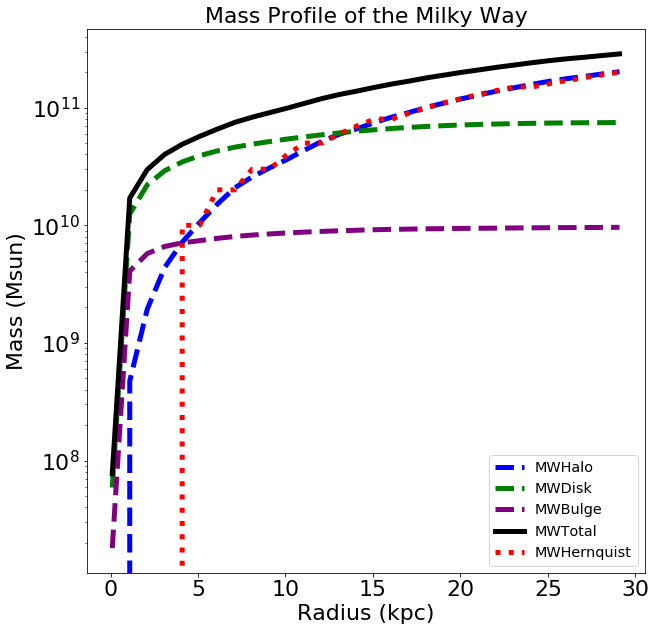

In [20]:
#plotting the Mass profile of the MW

#obtain mass arrays for each component as well as for the total 
MWHalo = MW.MassEnclosed(1, r)
MWDisk = MW.MassEnclosed(2, r)
MWBulge = MW.MassEnclosed(3, r)
MWTotal = MW.MassEnclosedTotal(r)

#calculate HernquistMass profile for each radius through a loop, plugging in scale heights to match halo mass calculated by MassEnclosed
#use total Mhalo mass (in units of 10^12 Msun) calculated from HW 3 
#Had a similar units problem to when I did the circular velocity functions
MWHernquist = np.zeros(len(r))

for i in range(len(r)):
    MWHernquist[i] = MW.HernquistMass(r[i]/u.kpc, 62, 1.975)/u.M_sun
    
MWHernquist = MWHernquist*u.M_sun

#plot them as a function of radius
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

#plot components calculated by MassEnclosedFunctions
ax.semilogy(r, MWHalo, color='blue', linewidth=5, linestyle='--', label='MWHalo')
ax.semilogy(r, MWDisk, color='green', linewidth=5, linestyle='--', label='MWDisk')
ax.semilogy(r, MWBulge, color='purple', linewidth=5, linestyle='--', label='MWBulge')
ax.semilogy(r, MWTotal, color='black', linewidth=5, label='MWTotal')

#plot Hernquist profile on top of DM component
ax.semilogy(r, MWHernquist, color='red', linewidth=5, linestyle=':', label='MWHernquist')

#add labels
plt.title("Mass Profile of the Milky Way", fontsize=22)
plt.xlabel("Radius (kpc)", fontsize=22)
plt.ylabel("Mass (Msun)", fontsize=22)

#adjust tick label font size
label_size = 22
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')



The scale radius chosen that best fits the calculated MW Halo component is 62 kpc. 

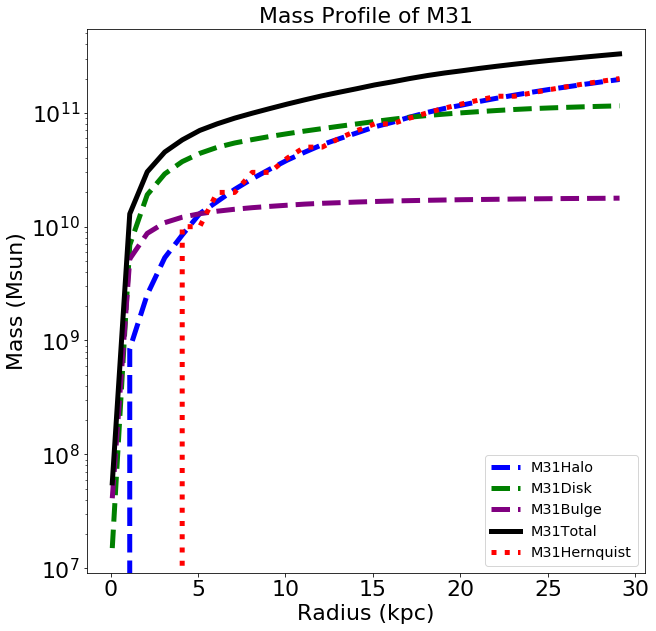

In [21]:
#plotting the Mass profile of the M31

#obtain mass arrays for each component as well as for the total 
M31Halo = M31.MassEnclosed(1, r)
M31Disk = M31.MassEnclosed(2, r)
M31Bulge = M31.MassEnclosed(3, r)
M31Total = M31.MassEnclosedTotal(r)

#calculate HernquistMass profile for each radius through a loop, plugging in scale heights to match halo mass calculated by MassEnclosed
#use total Mhalo mass (in units of 10^12 Msun) calculated from HW 3 
M31Hernquist = np.zeros(len(r))

for i in range(len(r)):
    M31Hernquist[i] = M31.HernquistMass(r[i]/u.kpc, 61, 1.921)/u.M_sun
    
M31Hernquist = M31Hernquist*u.M_sun

#plot them as a function of radius
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

#plot components calculated by MassEnclosedFunctions
ax.semilogy(r, M31Halo, color='blue', linewidth=5, linestyle='--', label='M31Halo')
ax.semilogy(r, M31Disk, color='green', linewidth=5, linestyle='--', label='M31Disk')
ax.semilogy(r, M31Bulge, color='purple', linewidth=5, linestyle='--', label='M31Bulge')
ax.semilogy(r, M31Total, color='black', linewidth=5, label='M31Total')

#plot Hernquist profile on top of DM component
ax.semilogy(r, M31Hernquist, color='red', linewidth=5, linestyle=':', label='M31Hernquist')

#add labels
plt.title("Mass Profile of M31", fontsize=22)
plt.xlabel("Radius (kpc)", fontsize=22)
plt.ylabel("Mass (Msun)", fontsize=22)

#adjust tick label font size
label_size = 22
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')


The scale radius chosen that best fits the calculated M31 Halo component is 61 kpc. Almost the same as that for the Milky Way!  This makes sense because the Milky Way and M31 have very similar dark matter masses

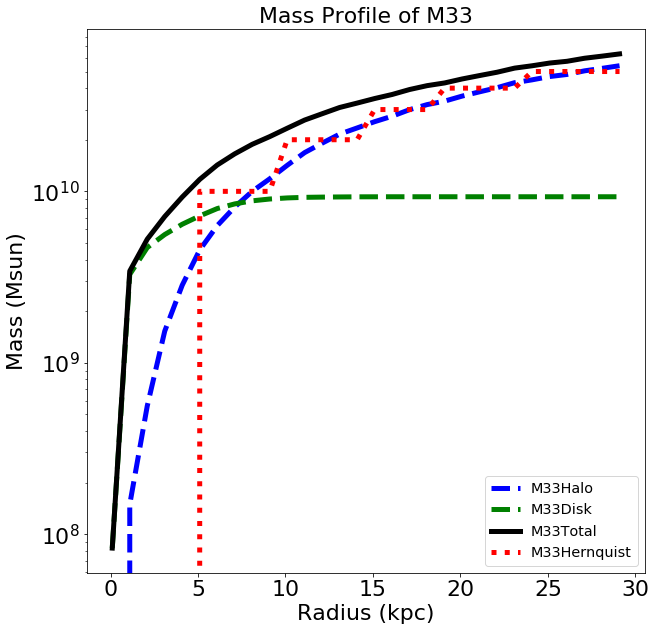

In [22]:
#plotting the Mass profile of the M33

#obtain mass arrays for each component as well as for the total (no need for bulge component because M33 has no bulge)
M33Halo = M33.MassEnclosed(1, r)
M33Disk = M33.MassEnclosed(2, r)
M33Total = M33.MassEnclosedTotal(r)

#calculate HernquistMass profile for each radius through a loop, plugging in scale heights to match halo mass calculated by MassEnclosed
#use total Mhalo mass (in units of 10^12 Msun) calculated from HW 3 
M33Hernquist = np.zeros(len(r))

for i in range(len(r)):
    M33Hernquist[i] = M33.HernquistMass(r[i]/u.kpc, 25, 0.187)/u.M_sun
    
M33Hernquist = M33Hernquist*u.M_sun

#plot them as a function of radius
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

#plot components calculated by MassEnclosedFunctions
ax.semilogy(r, M33Halo, color='blue', linewidth=5, linestyle='--', label='M33Halo')
ax.semilogy(r, M33Disk, color='green', linewidth=5, linestyle='--', label='M33Disk')
ax.semilogy(r, M33Total, color='black', linewidth=5, label='M33Total')

#plot Hernquist profile on top of DM component
ax.semilogy(r, M33Hernquist, color='red', linewidth=5, linestyle=':', label='M33Hernquist')

#add labels
plt.title("Mass Profile of M33", fontsize=22)
plt.xlabel("Radius (kpc)", fontsize=22)
plt.ylabel("Mass (Msun)", fontsize=22)

#adjust tick label font size
label_size = 22
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')



The scale radius chosen that best fits the calculated M33 halo component is 25 kpc.

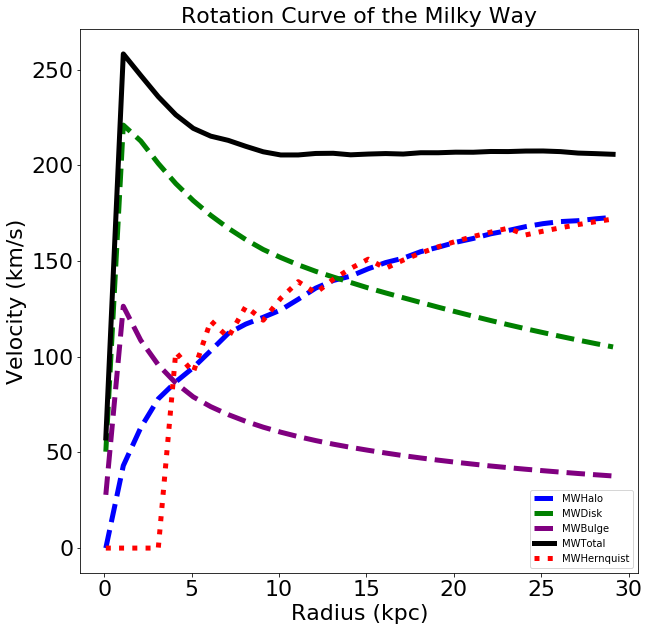

In [23]:
#plotting the rotation curve of the Milky Way

#obtain circular velocity arrays for each component of MW as well as the total circular velocity array
MWHaloCv = MW.CircularVelocity(1, r)
MWDiskCv = MW.CircularVelocity(2, r)
MWBulgeCv = MW.CircularVelocity(3, r)
MWTotalCv = MW.TotalCircularVelocity(r)

#calculate HernquistCircularVelocityt profile for each radius through a loop, plugging in scale heights that were matched
#to the mass profiles above
#use total Mhalo mass (in units of 10^12 Msun) calculated from HW 3 
MWHernquistCv = np.zeros(len(r))

for i in range(len(r)):
    MWHernquistCv[i] = MW.HernquistVCirc(r[i]/u.kpc, 62, 1.975)*(u.s/u.km)
    
MWHernquistCv = MWHernquistCv*(u.km/u.s)

#plot them as a function of radius
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

#plot components calculated by MassEnclosedFunctions
plt.plot(r, MWHaloCv, color='blue', linewidth=5, linestyle='--', label='MWHalo')
plt.plot(r, MWDiskCv, color='green', linewidth=5, linestyle='--', label='MWDisk')
plt.plot(r, MWBulgeCv, color='purple', linewidth=5, linestyle='--', label='MWBulge')
plt.plot(r, MWTotalCv, color='black', linewidth=5, label='MWTotal')

#plot Hernquist profile on top of DM component
plt.plot(r, MWHernquistCv, color='red', linewidth=5, linestyle=':', label='MWHernquist')

#add labels
plt.title("Rotation Curve of the Milky Way", fontsize=22)
plt.xlabel("Radius (kpc)", fontsize=22)
plt.ylabel("Velocity (km/s)", fontsize=22)

#adjust tick label font size
label_size = 22
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='medium')

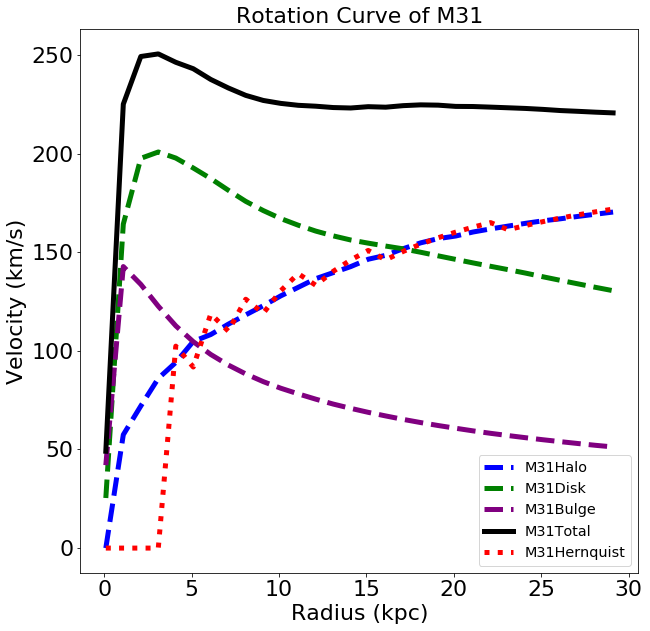

In [24]:
#plotting the rotation curve of M31

#obtain circular velocity arrays for each component of M31 as well as the total circular velocity array
M31HaloCv = M31.CircularVelocity(1, r)
M31DiskCv = M31.CircularVelocity(2, r)
M31BulgeCv = M31.CircularVelocity(3, r)
M31TotalCv = M31.TotalCircularVelocity(r)

#calculate HernquistCircularVelocityt profile for each radius through a loop, plugging in scale heights that were matched
#to the mass profiles above
#use total Mhalo mass (in units of 10^12 Msun) calculated from HW 3 
M31HernquistCv = np.zeros(len(r))

for i in range(len(r)):
    M31HernquistCv[i] = M31.HernquistVCirc(r[i]/u.kpc, 61, 1.921)*(u.s/u.km)
    
M31HernquistCv = M31HernquistCv*(u.km/u.s)

#plot them as a function of radius
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

#plot components calculated by MassEnclosedFunctions
plt.plot(r, M31HaloCv, color='blue', linewidth=5, linestyle='--', label='M31Halo')
plt.plot(r, M31DiskCv, color='green', linewidth=5, linestyle='--', label='M31Disk')
plt.plot(r, M31BulgeCv, color='purple', linewidth=5, linestyle='--', label='M31Bulge')
plt.plot(r, M31TotalCv, color='black', linewidth=5, label='M31Total')

#plot Hernquist profile on top of DM component
plt.plot(r, M31HernquistCv, color='red', linewidth=5, linestyle=':', label='M31Hernquist')

#add labels
plt.title("Rotation Curve of M31", fontsize=22)
plt.xlabel("Radius (kpc)", fontsize=22)
plt.ylabel("Velocity (km/s)", fontsize=22)

#adjust tick label font size
label_size = 22
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

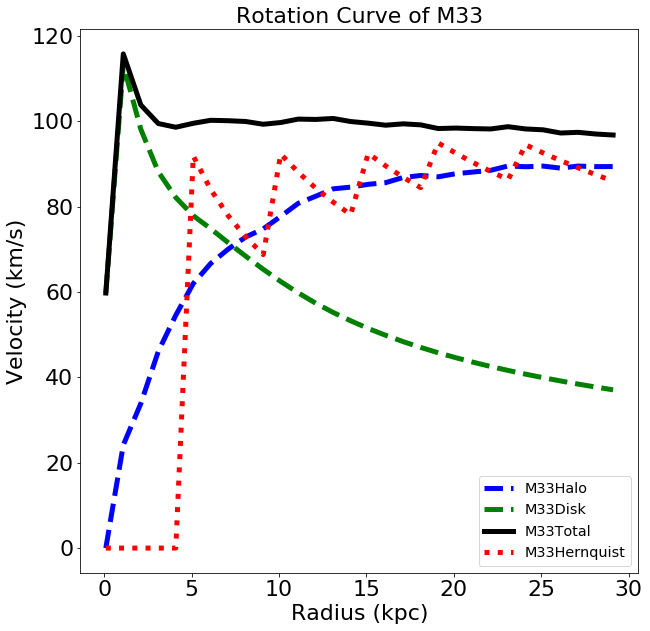

In [25]:
#plotting the rotation curve of M33

#obtain circular velocity arrays for each component of M33 as well as the total circular velocity array 
#(no need for bulge component because M33 has no bulge)
M33HaloCv = M33.CircularVelocity(1, r)
M33DiskCv = M33.CircularVelocity(2, r)
M33TotalCv = M33.TotalCircularVelocity(r)

#calculate HernquistCircularVelocityt profile for each radius through a loop, plugging in scale heights that were matched
#to the mass profiles above
#use total Mhalo mass (in units of 10^12 Msun) calculated from HW 3 
M33HernquistCv = np.zeros(len(r))

for i in range(len(r)):
    M33HernquistCv[i] = M31.HernquistVCirc(r[i]/u.kpc, 25, 0.187)*(u.s/u.km)
    
M33HernquistCv = M33HernquistCv*(u.km/u.s)

#plot them as a function of radius
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

#plot components calculated by MassEnclosedFunctions
plt.plot(r, M33HaloCv, color='blue', linewidth=5, linestyle='--', label='M33Halo')
plt.plot(r, M33DiskCv, color='green', linewidth=5, linestyle='--', label='M33Disk')
plt.plot(r, M33TotalCv, color='black', linewidth=5, label='M33Total')

#plot Hernquist profile on top of DM component
plt.plot(r, M33HernquistCv, color='red', linewidth=5, linestyle=':', label='M33Hernquist')

#add labels
plt.title("Rotation Curve of M33", fontsize=22)
plt.xlabel("Radius (kpc)", fontsize=22)
plt.ylabel("Velocity (km/s)", fontsize=22)

#adjust tick label font size
label_size = 22
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')